In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam,Nadam, SGD
import math
from sklearn.metrics import mean_squared_error

2022-10-10 13:19:42.426816: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-10 13:19:42.431329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 13:19:42.431341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('/home/shivanisri/Desktop/GRU/IBM.csv', index_col='Date', parse_dates=['Date'])
print(dataset.head())
dataset.shape

             Open   High    Low  Close    Volume Name
Date                                                 
2006-01-03  82.45  82.55  80.81  82.06  11715200  IBM
2006-01-04  82.20  82.50  81.33  81.95   9840600  IBM
2006-01-05  81.40  82.90  81.00  82.50   7213500  IBM
2006-01-06  83.95  85.03  83.41  84.95   8197400  IBM
2006-01-09  84.10  84.25  83.38  83.73   6858200  IBM


(3020, 6)

In [4]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
print("train",training_set.shape)
print("test",test_set.shape)

train (2769, 1)
test (251, 1)


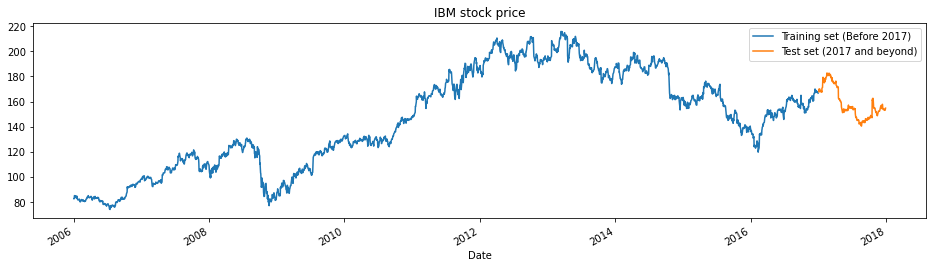

In [5]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(2769, 1)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(2709, 60)
(2709,)


In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(2709, 60, 1)

In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
print("len:",len(dataset_total))
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
print(inputs)
inputs = inputs.reshape(-1,1)
print("after reshape:",inputs)
inputs  = sc.transform(inputs)
print("transform:",inputs)

len: 3020
[157.43 157.7  158.49 156.95 154.97 154.22 155.53 155.89 151.   152.45
 152.9  151.15 151.52 151.16 152.94 154.06 154.44 154.33 153.91 153.34
 153.74 153.64 156.11 155.93 155.56 161.16 161.34 161.86 159.15 159.55
 159.93 160.72 163.   163.   162.38 163.19 164.66 164.41 163.8  162.2
 160.29 161.15 160.79 165.18 166.   166.72 166.79 169.95 169.89 169.85
 169.11 167.26 168.25 167.94 168.23 167.49 167.98 167.74 166.99 166.7
 167.87 169.87 169.39 169.92 169.8  168.09 167.76 168.01 168.48 168.18
 168.59 167.45 170.64 171.25 176.   179.25 178.88 179.2  177.07 175.58
 175.7  174.97 176.34 175.98 178.62 177.5  177.8  178.87 179.9  180.13
 181.92 182.79 181.57 180.79 181.34 182.5  181.49 181.25 180.63 182.55
 181.88 181.32 180.99 181.29 180.95 179.25 179.49 178.06 176.82 176.28
 179.   176.79 176.18 176.23 175.06 175.67 175.5  174.16 175.   174.49
 174.59 174.95 174.87 174.96 176.33 173.47 172.93 172.56 171.23 171.2
 171.36 171.3  171.69 162.64 162.4  162.11 161.57 162.04 161.1  160.48

In [9]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

2022-10-10 13:20:48.584978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-10 13:20:48.585001: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-10 13:20:48.585018: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shivanisri-Latitude-3420): /proc/driver/nvidia/version does not exist
2022-10-10 13:20:48.585203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50


/home/shivanisri/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 6s 83ms/step - loss: 0.1127
Epoch 2/50
19/19 [==============================] - 2s 90ms/step - loss: 0.0275
Epoch 3/50
19/19 [==============================] - 2s 100ms/step - loss: 0.0064
Epoch 4/50
19/19 [==============================] - 2s 96ms/step - loss: 0.0047
Epoch 5/50
19/19 [==============================] - 2s 98ms/step - loss: 0.0040
Epoch 6/50
19/19 [==============================] - 2s 97ms/step - loss: 0.0037
Epoch 7/50
19/19 [==============================] - 2s 101ms/step - loss: 0.0035
Epoch 8/50
19/19 [==============================] - 2s 100ms/step - loss: 0.0033
Epoch 9/50
19/19 [==============================] - 2s 98ms/step - loss: 0.0035
Epoch 10/50
19/19 [==============================] - 2s 102ms/step - loss: 0.0031
Epoch 11/50
19/19 [==============================] - 2s 99ms/step - loss: 0.0031
Epoch 12/50
19/19 [==============================] - 2s 106ms/step - loss: 0.0030
Epoch 13/50
19/19 [========================

In [12]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
print(len(X_test))
X_test = np.array(X_test)
print(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print("after reshape:",X_test)
GRU_predicted_stock_price = regressorGRU.predict(X_test)
print("predict:",GRU_predicted_stock_price)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
print("inverse_transform:",GRU_predicted_stock_price)

251
[[0.58812342 0.59002536 0.59559031 ... 0.66074951 0.65546633 0.6534235 ]
 [0.59002536 0.59559031 0.58474218 ... 0.65546633 0.6534235  0.66166526]
 [0.59559031 0.58474218 0.57079459 ... 0.6534235  0.66166526 0.67575373]
 ...
 [0.51366582 0.51606086 0.5147929  ... 0.56015779 0.55691744 0.56297549]
 [0.51606086 0.5147929  0.5184559  ... 0.55691744 0.56297549 0.5581854 ]
 [0.5147929  0.5184559  0.51359538 ... 0.56297549 0.5581854  0.56480699]]
after reshape: [[[0.58812342]
  [0.59002536]
  [0.59559031]
  ...
  [0.66074951]
  [0.65546633]
  [0.6534235 ]]

 [[0.59002536]
  [0.59559031]
  [0.58474218]
  ...
  [0.65546633]
  [0.6534235 ]
  [0.66166526]]

 [[0.59559031]
  [0.58474218]
  [0.57079459]
  ...
  [0.6534235 ]
  [0.66166526]
  [0.67575373]]

 ...

 [[0.51366582]
  [0.51606086]
  [0.5147929 ]
  ...
  [0.56015779]
  [0.55691744]
  [0.56297549]]

 [[0.51606086]
  [0.5147929 ]
  [0.5184559 ]
  ...
  [0.55691744]
  [0.56297549]
  [0.5581854 ]]

 [[0.5147929 ]
  [0.5184559 ]
  [0.513595

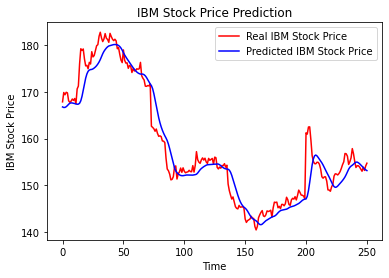

In [13]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [14]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.220646869049732.
